# 外交青書2025 テキストマイニング分析（R版）

## 概要

このノートブックでは、外務省が発行する「外交青書2025」第1章「国際情勢認識と日本外交の展望」のPDFファイルに対して、Rを使用したテキストマイニング分析を行います。

### 分析内容

1. **テキストの読み込み** - 抽出済みテキストファイルからデータを読み込み
2. **形態素解析** - RMeCabを使用して日本語テキストを単語に分解
3. **単語頻度分析** - 出現頻度の高い単語を特定
4. **共起分析** - 同時に出現する単語ペアを分析
5. **ワードクラウド生成** - 分析結果を視覚化

### 使用パッケージ

| パッケージ | 用途 |
|-----------|------|
| RMeCab | 日本語形態素解析 |
| dplyr | データ操作 |
| ggplot2 | グラフ描画 |
| wordcloud2 | ワードクラウド生成 |
| igraph | ネットワーク可視化 |

---
## 1. 環境設定

必要なパッケージをインストール・読み込みます。

### 前提条件
- MeCabがシステムにインストールされていること
- `sudo apt-get install mecab libmecab-dev mecab-ipadic-utf8`

In [1]:
# パッケージのインストール（未インストールの場合）
packages <- c("dplyr", "tidyr", "ggplot2", "stringr", 
              "wordcloud2", "igraph")

for (pkg in packages) {
  if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
    install.packages(pkg, repos = "https://cran.r-project.org")
  }
}

cat("必要なパッケージのインストール完了\n")


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union





Attaching package: ‘igraph’




The following object is masked from ‘package:tidyr’:

    crossing




The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union




The following objects are masked from ‘package:stats’:

    decompose, spectrum




The following object is masked from ‘package:base’:

    union




必要なパッケージのインストール完了


In [2]:
# パッケージの読み込み
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)

# 日本語フォント設定
theme_set(theme_gray(base_family = "Noto Sans CJK JP"))

# MeCabをシステムコマンドで呼び出す関数
mecab_parse <- function(text) {
  # 一時ファイルに書き込み
  temp_in <- tempfile(fileext = ".txt")
  temp_out <- tempfile(fileext = ".txt")
  
  # UTF-8で書き込み
  con <- file(temp_in, "w", encoding = "UTF-8")
  writeLines(text, con)
  close(con)
  
  # MeCabを実行（バッファサイズを増やす）
  system2("mecab", args = c("-b", "81920", temp_in, "-o", temp_out))
  
  # 結果を読み込み（エンコーディング指定）
  con <- file(temp_out, "r", encoding = "UTF-8")
  result <- readLines(con, warn = FALSE)
  close(con)
  
  # 一時ファイルを削除
  unlink(c(temp_in, temp_out))
  
  # パース結果をデータフレームに変換
  parsed_list <- list()
  for (i in seq_along(result)) {
    line <- result[i]
    if (is.na(line) || line == "EOS" || line == "" || !grepl("\t", line)) next
    
    tryCatch({
      parts <- strsplit(line, "\t", fixed = TRUE)[[1]]
      if (length(parts) >= 2) {
        word <- parts[1]
        info <- strsplit(parts[2], ",", fixed = TRUE)[[1]]
        parsed_list[[length(parsed_list) + 1]] <- data.frame(
          Term = word,
          Info1 = info[1],
          Info2 = if(length(info) > 1) info[2] else NA_character_,
          stringsAsFactors = FALSE
        )
      }
    }, error = function(e) {})
  }
  
  if (length(parsed_list) == 0) return(data.frame(Term = character(), Info1 = character(), Info2 = character()))
  do.call(rbind, parsed_list)
}

# MeCab頻度解析関数
mecab_freq <- function(text) {
  parsed <- mecab_parse(text)
  if (is.null(parsed) || nrow(parsed) == 0) return(data.frame())
  
  parsed %>%
    group_by(Term, Info1, Info2) %>%
    summarise(Freq = n(), .groups = "drop") %>%
    arrange(desc(Freq))
}

cat("パッケージの読み込み完了\n")
cat("MeCab関数を定義しました\n")

パッケージの読み込み完了


MeCab関数を定義しました


---
## 2. 設定とパラメータ

分析に使用する各種パラメータを定義します。

In [3]:
# ===== ファイル設定 =====
TEXT_PATH <- "extracted_text.txt"  # Pythonで抽出済みのテキストファイル
OUTPUT_CSV <- "word_frequency_results_r.csv"
COOCCURRENCE_CSV <- "cooccurrence_results_r.csv"

# ===== 形態素解析の設定 =====
# 抽出対象の品詞
TARGET_POS <- c("名詞", "動詞", "形容詞")

# ストップワード（除外する一般的な単語）
STOPWORDS <- c(
  # 形式名詞
  "こと", "もの", "ため", "よう",
  # 代名詞
  "これ", "それ", "あれ", "ここ", "そこ", "あそこ",
  "どこ", "どれ", "なに", "何",
  # 補助動詞・基本動詞
  "する", "いる", "ある", "なる", "れる", "られる", "せる",
  "できる", "おる", "くる", "来る", "行く", "いく",
  # 指示詞
  "この", "その", "あの", "どの",
  # 否定
  "ない", "なく",
  # 接尾辞
  "等", "的", "化", "性", "上", "中", "下", "内", "外",
  # 時間・番号
  "年", "月", "日", "号", "第", "章",
  # 接続詞等
  "ほか", "また", "および", "かつ", "ただし", "なお", "または"
)

cat("対象テキストファイル:", TEXT_PATH, "\n")
cat("抽出品詞:", paste(TARGET_POS, collapse = ", "), "\n")
cat("ストップワード数:", length(STOPWORDS), "語\n")

対象テキストファイル: extracted_text.txt 


抽出品詞: 名詞, 動詞, 形容詞 


ストップワード数: 55 語


---
## 3. テキストファイルの読み込み

Pythonで抽出済みのテキストファイルを読み込みます。

In [4]:
# テキストファイルを読み込み
cat("テキストファイルを読み込み中...\n\n")

raw_text <- paste(readLines(TEXT_PATH, encoding = "UTF-8"), collapse = "\n")

cat(sprintf("抽出文字数: %s 文字\n", format(nchar(raw_text), big.mark = ",")))

テキストファイルを読み込み中...



抽出文字数: 6,546 文字


In [5]:
# 抽出したテキストの先頭部分を確認
cat(strrep("=", 60), "\n")
cat("抽出テキスト（先頭500文字）\n")
cat(strrep("=", 60), "\n")
cat(substr(raw_text, 1, 500), "\n")

抽出テキスト（先頭500文字）


第1章 国際情勢認識と日本外交の展望
11
第第 章章 国際情勢認識と日本外交の展望
日本が外交安全保障及び経済上の国益を確保 要がある。このためには、国際情勢の潮流を冷
し、また、危機を未然に防ぎ、海外在留邦人を 静に把握し、変化に適応しながら、戦略的・機
含む国民の生活の安全と繁栄を確保するために 動的に外交を展開していくことが求められる。
は、自由、民主主義、人権、法の支配といった 本章では、日本を取り巻く国際情勢認識及び
価値や原則に基づく国際秩序を維持・強化し、 日本外交の展望について概観する。
平和で安定した国際環境を能動的に創出する必
11 情勢認識
現在、国際社会は再び歴史の大きな転換点に さらに、一部の国家は、急速かつ不透明な軍
ある。冷戦後の一定期間、安定的な国際秩序が 事力の強化を進め、独自の歴史観に基づき既存
世界に拡大した。圧倒的な国力を有する米国 の国際秩序に対する挑戦的姿勢と自己主張を強
と、日本を含む先進民主主義国が自由、民主主 めているほか、経済的な依存関係を自らの政治
義、基本的人権の尊重、法の支配などの価値や 的目的の実現のために「武器化」するとい 


---
## 4. テキストの前処理（クリーニング）

形態素解析の精度を高めるため、テキストから不要な文字を除去します。

In [6]:
clean_text <- function(text) {
  # 数字を除去（半角・全角）
  text <- str_replace_all(text, "[0-9０-９]+", "")
  
  # 英字を除去（半角・全角）
  text <- str_replace_all(text, "[a-zA-Zａ-ｚＡ-Ｚ]+", "")
  
  # 記号・空白を除去
  text <- str_replace_all(text, "[（）()【】「」『』・、。：；！？]+", " ")
  
  # 連続する空白を1つに
  text <- str_replace_all(text, "\\s+", " ")
  
  return(str_trim(text))
}

# クリーニングの実行
cleaned_text <- clean_text(raw_text)

cat(sprintf("クリーニング前: %s 文字\n", format(nchar(raw_text), big.mark = ",")))
cat(sprintf("クリーニング後: %s 文字\n", format(nchar(cleaned_text), big.mark = ",")))
cat(sprintf("削減率: %.1f%%\n", (1 - nchar(cleaned_text) / nchar(raw_text)) * 100))

クリーニング前: 6,546 文字


クリーニング後: 6,172 文字


削減率: 5.7%


---
## 5. 形態素解析

RMeCabを使用して日本語テキストを形態素（単語）に分解します。

In [7]:
# 形態素解析を実行
cat("形態素解析を実行中...\n")

# 形態素解析（品詞情報付き）
mecab_result <- mecab_freq(cleaned_text)

# 結果をフィルタリング
words_df <- mecab_result %>%
  filter(Info1 %in% TARGET_POS) %>%           # 指定品詞のみ
  filter(!(Info2 %in% c("非自立", "代名詞", "数"))) %>%  # サブカテゴリ除外
  filter(nchar(Term) > 1) %>%                  # 1文字の単語を除外
  filter(!(Term %in% STOPWORDS)) %>%          # ストップワードを除外
  arrange(desc(Freq))

cat(sprintf("\n抽出単語数: %s 語\n", format(sum(words_df$Freq), big.mark = ",")))
cat(sprintf("ユニーク単語数: %s 語\n", format(nrow(words_df), big.mark = ",")))

形態素解析を実行中...



抽出単語数: 1,385 語


ユニーク単語数: 608 語


In [8]:
# 形態素解析の結果サンプルを表示
cat("抽出された単語（上位20語）:\n")
head(words_df, 20)

抽出された単語（上位20語）:


Term,Info1,Info2,Freq
<chr>,<chr>,<chr>,<int>
国際,名詞,一般,56
社会,名詞,一般,29
経済,名詞,一般,20
日本,名詞,固有名詞,17
安全,名詞,形容動詞語幹,16
含む,動詞,自立,15
秩序,名詞,一般,15
課題,名詞,一般,15
重要,名詞,形容動詞語幹,14


---
## 6. 単語頻度分析

抽出した単語の出現回数を分析し、可視化します。

In [9]:
# 上位30語を表示
TOP_N <- 30

cat(strrep("=", 60), "\n")
cat(sprintf("単語頻度ランキング（上位%d語）\n", TOP_N))
cat(strrep("=", 60), "\n")

top_words <- head(words_df, TOP_N)
max_freq <- max(top_words$Freq)

for (i in 1:nrow(top_words)) {
  word <- top_words$Term[i]
  freq <- top_words$Freq[i]
  bar_len <- round(freq / max_freq * 30)
  bar <- paste(rep("█", bar_len), collapse = "")
  cat(sprintf("%2d. %-12s %3d %s\n", i, word, freq, bar))
}

単語頻度ランキング（上位30語）


 1. 国際        56 ██████████████████████████████
 2. 社会        29 ████████████████
 3. 経済        20 ███████████
 4. 日本        17 █████████
 5. 安全        16 █████████
 6. 含む        15 ████████
 7. 秩序        15 ████████
 8. 課題        15 ████████
 9. 重要        14 ████████
10. 安定        13 ███████
11. 情勢        13 ███████
12. 情報        13 ███████
13. グローバル  12 ██████
14. 保障        11 ██████
15. 世界        10 █████
16. 外交        10 █████
17. ウクライナ   9 █████
18. 平和         9 █████
19. 技術         9 █████
20. 求め         9 █████
21. ロシア      8 ████
22. 地域         8 ████
23. 環境         8 ████
24. 認識         8 ████
25. 依存         7 ████
26. 基づく      7 ████
27. 強化         7 ████
28. 拡大         7 ████
29. 発展         7 ████
30. 関係         7 ████


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_stringMetric, as.graphicsAnnot(x$label)):
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


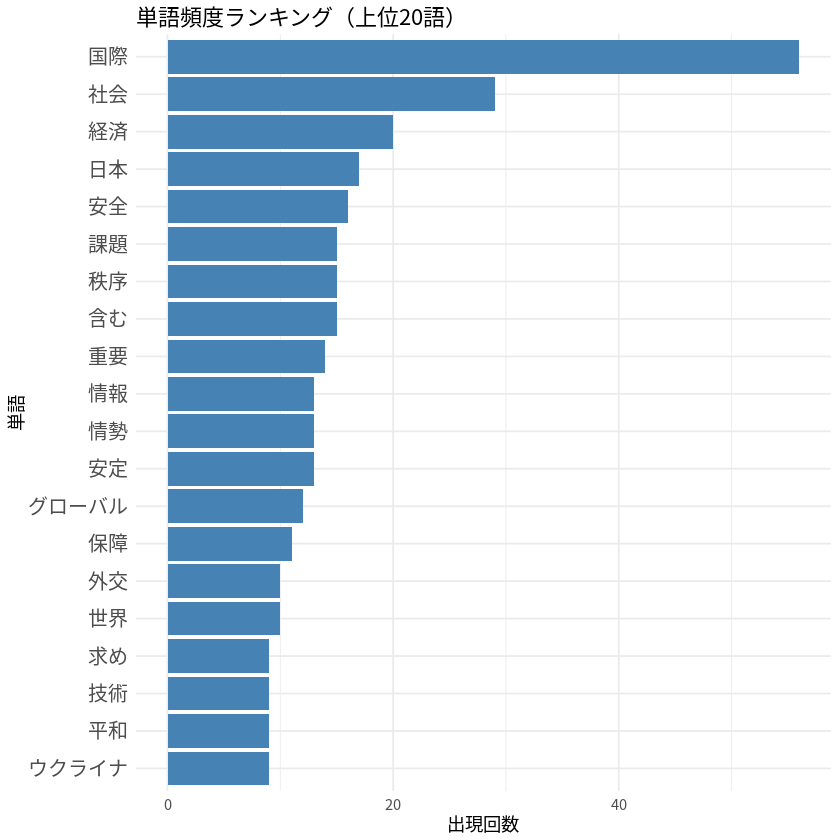

In [10]:
# 棒グラフで可視化
top20 <- head(words_df, 20)

ggplot(top20, aes(x = reorder(Term, Freq), y = Freq)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "単語頻度ランキング（上位20語）",
       x = "単語",
       y = "出現回数") +
  theme_minimal(base_family = "Noto Sans CJK JP") +
  theme(axis.text.y = element_text(size = 12))

---
## 7. 共起分析

同時に出現する単語ペアを分析します。

In [11]:
# 文単位で共起分析
cat("共起分析を実行中...\n")

# テキストを文に分割
sentences <- unlist(str_split(raw_text, "[。！？\n]+"))
sentences <- sentences[nchar(sentences) > 10]  # 短すぎる文を除外

cat(sprintf("文の数: %d\n", length(sentences)))

# 上位50語のみを共起分析対象とする
top50_words <- head(words_df$Term, 50)

# 各文から単語を抽出して共起をカウント
cooccurrence_list <- list()

for (sent in sentences) {
  tryCatch({
    # 文を形態素解析
    sent_df <- mecab_freq(sent)
    
    # 上位50語に含まれる単語のみ抽出
    sent_words <- unique(sent_df$Term[sent_df$Term %in% top50_words])
    
    # 単語ペアを作成
    if (length(sent_words) >= 2) {
      pairs <- combn(sort(sent_words), 2, simplify = FALSE)
      for (pair in pairs) {
        key <- paste(pair, collapse = "-")
        if (is.null(cooccurrence_list[[key]])) {
          cooccurrence_list[[key]] <- 0
        }
        cooccurrence_list[[key]] <- cooccurrence_list[[key]] + 1
      }
    }
  }, error = function(e) {})
}

# 共起データフレームを作成
cooccurrence_df <- data.frame(
  pair = names(cooccurrence_list),
  count = unlist(cooccurrence_list),
  stringsAsFactors = FALSE
) %>%
  arrange(desc(count)) %>%
  separate(pair, into = c("word1", "word2"), sep = "-")

cat(sprintf("\n共起ペア数: %s ペア\n", format(nrow(cooccurrence_df), big.mark = ",")))

共起分析を実行中...


文の数: 187



共起ペア数: 400 ペア


In [12]:
# 共起頻度上位20ペアを表示
cat(strrep("=", 50), "\n")
cat("共起頻度ランキング（上位20ペア）\n")
cat(strrep("=", 50), "\n")

top20_pairs <- head(cooccurrence_df, 20)
for (i in 1:nrow(top20_pairs)) {
  cat(sprintf("%2d. %s - %s: %d回\n", 
              i, 
              top20_pairs$word1[i], 
              top20_pairs$word2[i], 
              top20_pairs$count[i]))
}

共起頻度ランキング（上位20ペア）


 1. 国際 - 社会: 24回
 2. 国際 - 秩序: 12回
 3. 保障 - 安全: 11回
 4. 国際 - 情勢: 9回
 5. 国際 - 日本: 8回
 6. 国際 - 基づく: 6回
 7. 基づく - 秩序: 6回
 8. 国際 - 安定: 6回
 9. 含む - 国際: 6回
10. 国際 - 課題: 6回
11. 国際 - 認識: 5回
12. 外交 - 日本: 5回
13. 国際 - 支配: 5回
14. 国際 - 発展: 5回
15. 国際 - 経済: 5回
16. 国際 - 外交: 4回
17. 情勢 - 日本: 4回
18. 情勢 - 認識: 4回
19. 日本 - 認識: 4回
20. 安全 - 経済: 4回


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <e5>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <85>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <b1>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <e8>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <b5>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <b7>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <8d>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <88>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <83>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <bc>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <e3>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <82>”


Warning message in title(...):
“conversion failure on '共起ネットワーク' in 'mbcsToSbcs': dot substituted for <af>”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in text.default(x0, y0, labels = lbl, col = col, family = fam, font = fnt, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”



ノード数: 30
エッジ数: 40


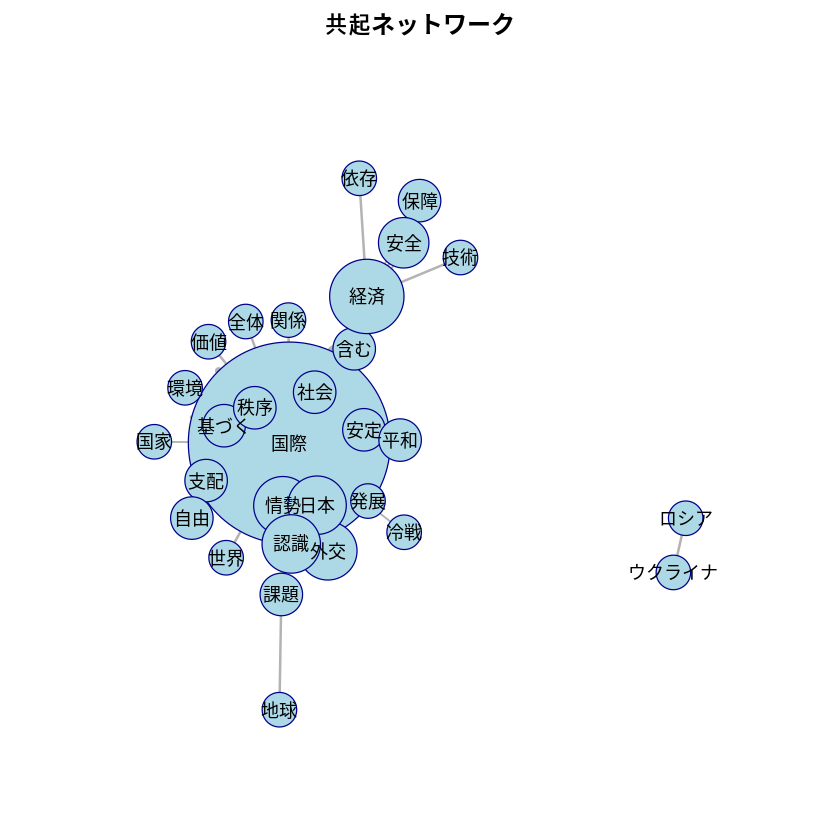

In [13]:
# 共起ネットワークの可視化
library(igraph)

# 上位40ペアでネットワーク作成
top_pairs <- head(cooccurrence_df, 40) %>%
  filter(count >= 2)

if (nrow(top_pairs) > 0) {
  # グラフを作成
  g <- graph_from_data_frame(top_pairs[, c("word1", "word2", "count")], directed = FALSE)
  E(g)$weight <- top_pairs$count
  
  # ノードサイズを次数に基づいて設定
  V(g)$size <- degree(g) * 3 + 10
  
  # エッジの太さを重みに基づいて設定
  E(g)$width <- E(g)$weight * 0.5
  
  # プロット
  par(mar = c(0, 0, 2, 0))
  plot(g,
       layout = layout_with_fr(g),
       vertex.color = "lightblue",
       vertex.frame.color = "darkblue",
       vertex.label.family = "Noto Sans CJK JP",
       vertex.label.cex = 0.9,
       vertex.label.color = "black",
       edge.color = "gray70",
       main = "共起ネットワーク")
  
  cat(sprintf("\nノード数: %d\n", vcount(g)))
  cat(sprintf("エッジ数: %d\n", ecount(g)))
}

---
## 8. 品詞別分析

テキスト全体の品詞構成を分析します。

In [14]:
# 品詞別の出現回数
all_mecab <- mecab_freq(cleaned_text)

pos_df <- all_mecab %>%
  group_by(Info1) %>%
  summarise(count = sum(Freq), .groups = "drop") %>%
  arrange(desc(count)) %>%
  mutate(percentage = count / sum(count) * 100)

cat(strrep("=", 40), "\n")
cat("品詞別出現回数\n")
cat(strrep("=", 40), "\n")

head(pos_df, 10)

品詞別出現回数


Info1,count,percentage
<chr>,<int>,<dbl>
名詞,1604,49.8911353
助詞,938,29.1757387
動詞,380,11.8195956
助動詞,156,4.8522551
副詞,30,0.9331260
接頭詞,30,0.9331260
連体詞,28,0.8709176
接続詞,27,0.8398134
形容詞,18,0.5598756


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Noto Sans CJK JP' not found in PostScript font database”


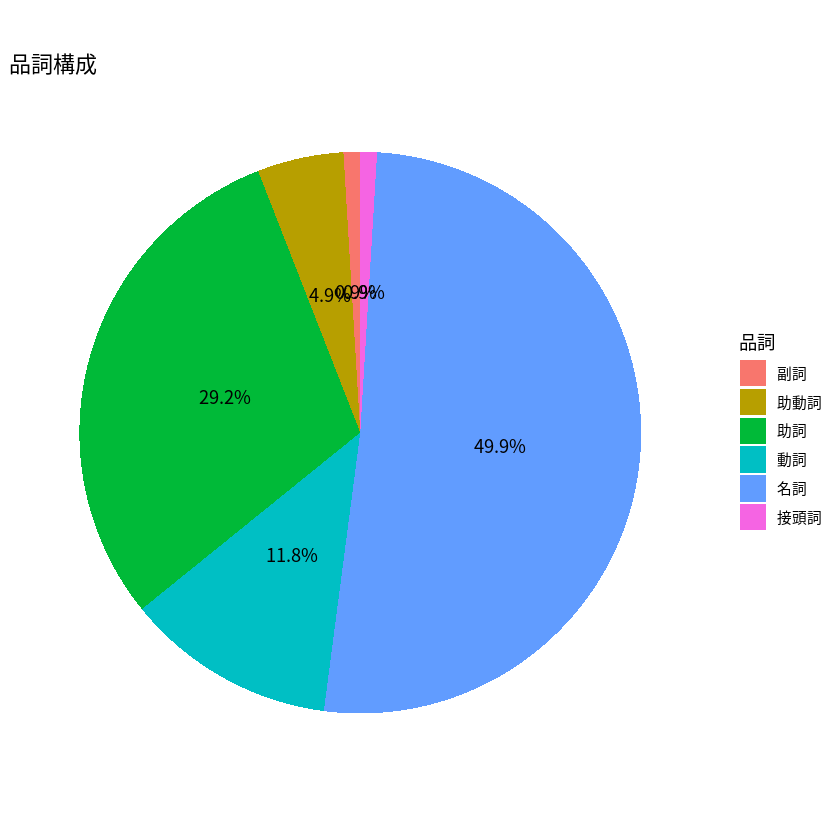

In [15]:
# 円グラフで可視化
top_pos <- head(pos_df, 6)

ggplot(top_pos, aes(x = "", y = count, fill = Info1)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y", start = 0) +
  labs(title = "品詞構成", fill = "品詞") +
  theme_minimal(base_family = "Noto Sans CJK JP") +
  theme(axis.text = element_blank(),
        axis.title = element_blank(),
        panel.grid = element_blank()) +
  geom_text(aes(label = sprintf("%.1f%%", percentage)),
            position = position_stack(vjust = 0.5))

---
## 9. ワードクラウド生成

単語の出現頻度を視覚的に表現するワードクラウドを生成します。

In [16]:
# wordcloud2を使用したワードクラウド
library(wordcloud2)

# データを準備
wc_data <- words_df %>%
  select(word = Term, freq = Freq) %>%
  head(100)

# ワードクラウドを生成
wordcloud2(wc_data, 
           size = 0.8,
           color = "random-dark",
           backgroundColor = "white",
           fontFamily = "Noto Sans CJK JP")

HTML widgets cannot be represented in plain text (need html)

---
## 10. 結果の保存

分析結果をCSVファイルに保存します。

In [17]:
# 単語頻度結果を保存
output_words <- words_df %>%
  mutate(rank = row_number()) %>%
  select(順位 = rank, 単語 = Term, 品詞 = Info1, 出現回数 = Freq)

write.csv(output_words, OUTPUT_CSV, row.names = FALSE, fileEncoding = "UTF-8")
cat(sprintf("単語頻度結果を保存しました: %s\n", OUTPUT_CSV))
cat(sprintf("保存単語数: %d 語\n", nrow(output_words)))

単語頻度結果を保存しました: word_frequency_results_r.csv


保存単語数: 608 語


In [18]:
# 共起分析結果を保存
output_cooc <- cooccurrence_df %>%
  mutate(rank = row_number()) %>%
  select(順位 = rank, 単語1 = word1, 単語2 = word2, 共起回数 = count)

write.csv(output_cooc, COOCCURRENCE_CSV, row.names = FALSE, fileEncoding = "UTF-8")
cat(sprintf("共起分析結果を保存しました: %s\n", COOCCURRENCE_CSV))
cat(sprintf("保存ペア数: %d ペア\n", nrow(output_cooc)))

共起分析結果を保存しました: cooccurrence_results_r.csv


保存ペア数: 400 ペア


---
## 11. 分析結果のまとめ

外交青書2025 第1章の分析結果をまとめます。

In [19]:
# 分析結果のサマリー
cat(strrep("=", 60), "\n")
cat("分析結果サマリー（R版）\n")
cat(strrep("=", 60), "\n")

cat("\n【基本統計】\n")
cat(sprintf("  抽出文字数: %s 文字\n", format(nchar(raw_text), big.mark = ",")))
cat(sprintf("  総単語数: %s 語\n", format(sum(words_df$Freq), big.mark = ",")))
cat(sprintf("  ユニーク単語数: %s 語\n", format(nrow(words_df), big.mark = ",")))
cat(sprintf("  共起ペア数: %s ペア\n", format(nrow(cooccurrence_df), big.mark = ",")))

cat("\n【上位10語】\n")
for (i in 1:min(10, nrow(words_df))) {
  cat(sprintf("  %2d. %s: %d回\n", i, words_df$Term[i], words_df$Freq[i]))
}

cat("\n【共起頻度 上位5ペア】\n")
for (i in 1:min(5, nrow(cooccurrence_df))) {
  cat(sprintf("  %d. %s - %s: %d回\n", 
              i, 
              cooccurrence_df$word1[i], 
              cooccurrence_df$word2[i], 
              cooccurrence_df$count[i]))
}

cat("\n【出力ファイル】\n")
cat(sprintf("  - %s: 単語頻度データ\n", OUTPUT_CSV))
cat(sprintf("  - %s: 共起分析データ\n", COOCCURRENCE_CSV))

cat("\n", strrep("=", 60), "\n")
cat("分析完了\n")
cat(strrep("=", 60), "\n")

分析結果サマリー（R版）



【基本統計】


  抽出文字数: 6,546 文字


  総単語数: 1,385 語


  ユニーク単語数: 608 語


  共起ペア数: 400 ペア



【上位10語】


   1. 国際: 56回
   2. 社会: 29回
   3. 経済: 20回
   4. 日本: 17回
   5. 安全: 16回
   6. 含む: 15回
   7. 秩序: 15回
   8. 課題: 15回
   9. 重要: 14回
  10. 安定: 13回



【共起頻度 上位5ペア】


  1. 国際 - 社会: 24回
  2. 国際 - 秩序: 12回
  3. 保障 - 安全: 11回
  4. 国際 - 情勢: 9回
  5. 国際 - 日本: 8回



【出力ファイル】


  - word_frequency_results_r.csv: 単語頻度データ


  - cooccurrence_results_r.csv: 共起分析データ


分析完了


---
## 付録: セッション情報

In [20]:
sessionInfo()

R version 4.2.2 Patched (2022-11-10 r83330)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 12 (bookworm)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.11.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] igraph_2.2.1     wordcloud2_0.2.1 stringr_1.6.0    ggplot2_4.0.1   
[5] tidyr_1.3.1      dplyr_1.1.4     

loaded via a namespace (and not attached):
 [1] pillar_1.11.1      compiler_4.2.2     RColorBrewer_1.1-3 base64enc_0.1-3   
 [5]